In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
import talib as ta

In [ ]:
%matplotlib inline
sns.set_theme(rc={"figure.figsize" : [20,5]},
              style='dark')
#sns.set_style("dark")
sns.set_context(context='notebook')
plt.style.use('dark_background')

In [33]:
activo = 'ETH-USD'
df = yf.Ticker(activo)
df = df.history(start='2018-01-01', end='2024-11-28')

Resultados previos, 20 y 25

In [34]:
# Cálculo de EMA
df['EMA_50'] = ta.EMA(df['Close'], timeperiod=20)
df['EMA_200'] = ta.EMA(df['Close'], timeperiod=25)

In [35]:
# método de tendencias
df['Signal'] = 0

df.loc[df['EMA_50'] > df['EMA_200'], 'Signal'] = 1 # compra
df.loc[df['EMA_50'] < df['EMA_200'], 'Signal'] = -1 # venta

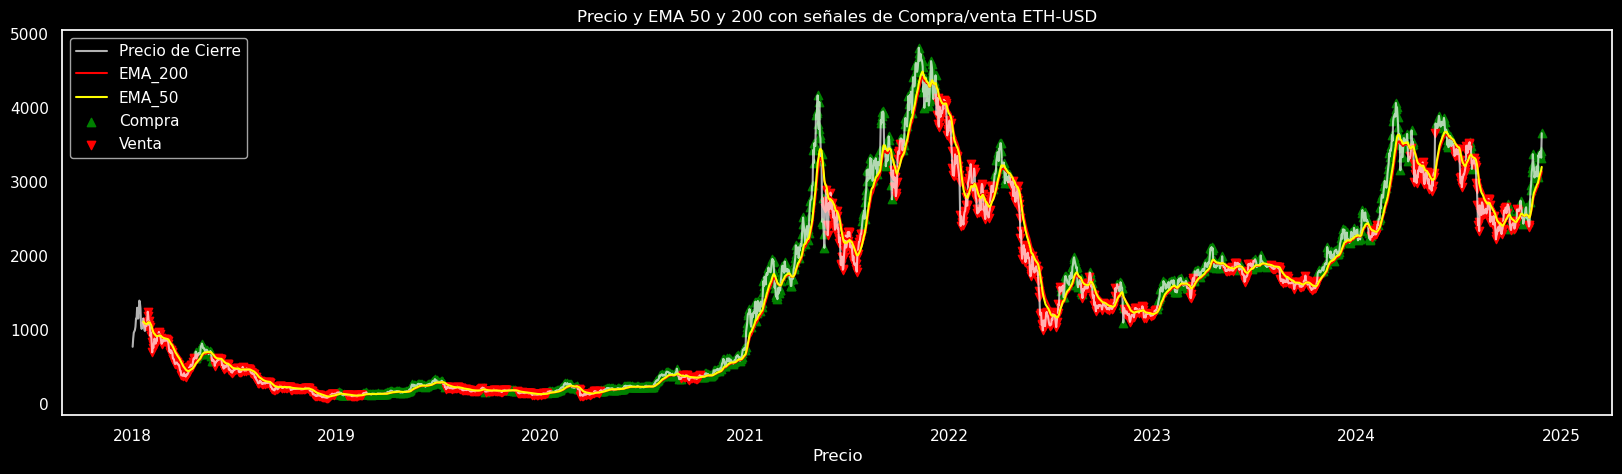

In [ ]:
# Gráfico
plt.plot(df.index, df['Close'], label = 'Precio de Cierre', color='white', alpha=0.7)
plt.plot(df.index, df['EMA_200'], label = 'EMA_200', color='red')
plt.plot(df.index, df['EMA_50'], label = 'EMA_50', color='yellow')
plt.scatter(df.index[df['Signal'] == 1], df['Close'][df['Signal'] == 1],
             marker='^', color='green', label='Compra', alpha=1)
plt.scatter(df.index[df['Signal'] == -1], df['Close'][df['Signal'] == -1], 
            marker='v', color='red', label='Venta', alpha=1)

plt.title(f'Precio y EMA 50 y 200 con señales de Compra/venta {activo}')
plt.xlabel(f'Fecha')
plt.xlabel(f'Precio')
plt.legend()
plt.show()

In [37]:
# Simular ejecución de ordenes
df['Position'] = df['Signal'].shift()

In [38]:
# Definir comisiones y slippage
commission = 0.001  # 0.1% por operación
slippage = 0.0005  # 0.05% de slippage en cada operación

In [39]:
# Calcular los retornos de la estrategia con comisiones y slippage

df['Returns'] = df['Close'].pct_change() # Retornos diarios del activo
df['Strategy_Returns'] = df['Position'] * df['Returns']

In [40]:
# Aplicar comisiones y Slippage 
# (Ajusta los valores de comisiones y slippage según el broker)
df['Strategy_Returns'] -= (abs(df['Position'].diff()) * (commission + slippage)) 

In [41]:
# Eliminar NaNs
df.dropna(inplace=True)

In [42]:
# calcular el rendimiento total y anualizado
# Rendimiento anualizado
total_return = (df['Strategy_Returns'] + 1).prod() - 1
annualized_return = (1 + total_return) ** (252 / len(df)) - 1 # Ajustado por 252 días de trading
print(f'Rendimiento Total: {total_return:.2%}')
print(f'Rendimiento Anualizado: {annualized_return:.2%}')

Rendimiento Total: 2194.86%
Rendimiento Anualizado: 37.16%


In [43]:
# Ratio de Sharpe
risk_free_rate = 0.04
excess_return = df['Strategy_Returns'].mean() - (risk_free_rate / 252)
sharpe_ratio = excess_return / df['Strategy_Returns'].std()
print(f'Ratio de Sharpe: {sharpe_ratio:2f}')

Ratio de Sharpe: 0.046813


In [44]:
# Drawdown Máximo
df['Cumulative_Returns'] = (df['Strategy_Returns'] + 1).cumprod()
df['Peak'] = df['Cumulative_Returns'].cummax()
df['Drawdown'] = (df['Cumulative_Returns'] - df['Peak']) / df['Peak']
max_drawdown = df['Drawdown'].min()
print(f'Máximo Drawdown: {max_drawdown:.2%}')

Máximo Drawdown: -84.61%


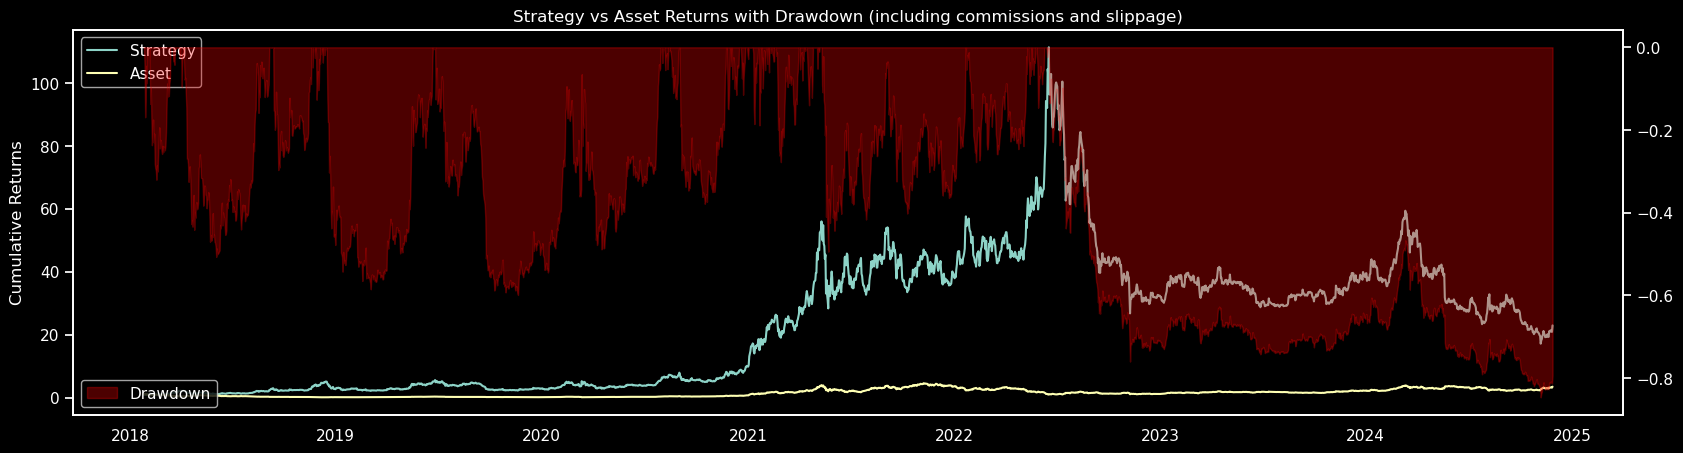

In [45]:
# Graficar el rendimiento de la estrategia frente al activo
fig, ax1 = plt.subplots()

# Graficar los rendimiento acumulados de la estrategia
ax1.plot(df.index, df['Cumulative_Returns'], label='Strategy')

#Gráficar los rendimiento acumulados del activo directamente usando Close
ax1.plot(df.index, (df['Close'] / df['Close'].iloc[0]), label='Asset')
ax1.set_ylabel('Cumulative Returns')

# Gráficar el drawdown coloreando
ax2 = ax1.twinx()
ax2.fill_between(df.index, df['Drawdown'], 0 , color='red', alpha=0.3, label='Drawdown')

# Configurar leyendas y títulos
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
plt.title('Strategy vs Asset Returns with Drawdown (including commissions and slippage)')

plt.show()